# Few Shot Learning- Meta Learning

**Notebook內容：**
1. 資料探索與資料讀取
2. 模型訓練
3. 預測&評估
4. 練習
5. 參考資料(連結+連結說明)

延續上一份教材，我們已經之知道Few shot learning的model有哪些，那這邊我沒會把model與配合的訓練框架組裝起來

## 1.資料探索與資料讀取

In [1]:
# Download model_tools
!git clone https://github.com/DeepStudio-TW/small-data-ssl-lecture.git
%cd small-data-ssl-lecture

fatal: destination path 'small-data-ssl-lecture' already exists and is not an empty directory.


In [5]:
# 升級 gdown 套件
!pip install -q --upgrade gdown
# Download dataset
!gdown -q  https://drive.google.com/uc?id=1XagZtTeUhFWiXvlZabja0XJhBMwQFl6j&export=download
# Unzip the files
!tar zxf  mnistm_half.tar.gz

### 1.1 範例內容
* 資料來源: 
    * Source: [MNIST](http://yann.lecun.com/exdb/mnist/) 0~9 數字圖片資料
    * Target: [MNIST-M](https://paperswithcode.com/dataset/mnist-m) 0~9 數字圖片混入BSDS500照片資料庫背景

* Label: 
    * Source data label 0~9
    * target data 不使用label訓練，純粹驗證用

In [1]:
# 讀取基本套件
import os
from glob import glob
import numpy as np
import matplotlib.pyplot as plt
# Backend: pytorch
import torch

In [2]:
# 設一個 show data和label的function
def show_data(imgs, titles,cmap=None):
    # imshow, 縮放模式為nearest。
    plt.figure(figsize=(18, 18))
    for id,(img,title) in enumerate(zip(imgs,titles)):
        plt.subplot(1, len(titles), id+1)
        fig = plt.imshow(img,interpolation='nearest',cmap=cmap)
        plt.axis("off")
        plt.title(title)

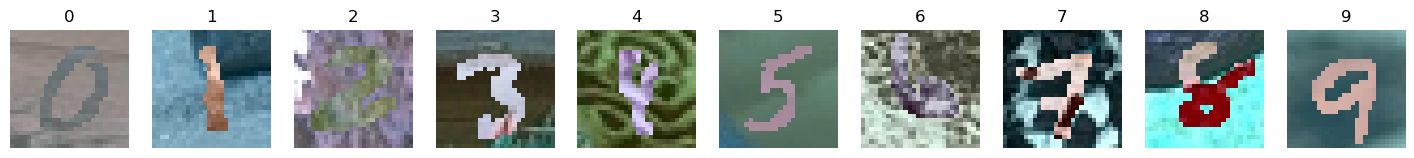

In [3]:
# 看source data: 
titles = ['0', '1', '2', '3', '4', '5', '6', '7', '8', '9']
example_files=[glob(f"mnistm_half/mnist_m_test/{i}/*.png")[0] for i in titles]
show_data([*map(plt.imread,example_files)],titles)

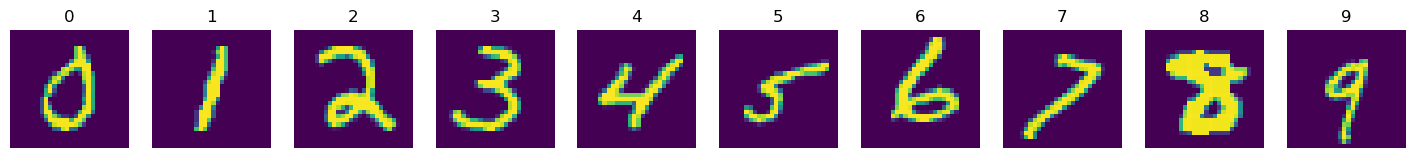

In [4]:
# 看target data
example_files=[glob(f"mnistm_half/mnist_train/{i}/*.png")[0] for i in titles]
show_data([*map(plt.imread,example_files)],titles)

### 1.2 Data Loader設計
這邊我們三個loader
* source: 來源資料集，有MNIST圖片，也有對應的label
* target: 目標資料集，只有少量MNIST-M 圖片，也有對應的label
* test: 測試資料集，有MNIST-M圖片，也有對應的label

Data Loader的要件:
* dataset: torchvision的VisionDataset，我們這邊使用ImageFolder作，只要把圖片依照分類放進資料夾就能依照資料夾名稱指定分類：
```
data_root
|--class 1
|   |--image 1
|   |--image 2
|   ...
|--class 2
|   |--image 3
...
```
* transform: augmentation function，這邊使用torchvision.transforms來做，也推薦[cv2 wrapaffine](https://theailearner.com/tag/cv2-warpaffine/)或者[aubmentation](https://github.com/albumentations-team/albumentations)，因為這是Deep Learning CV的基本所以這邊不多贅述。

* Transfer Learning Methods用的Loader:

In [5]:
import torchvision.transforms as tvt
import torchvision.datasets as tvds
from torch.utils import data as tud

train_transform = tvt.Compose([
    # 旋轉15度內 (Augmentation)，旋轉後空的地方補0
    tvt.RandomRotation(15, fill=(0,0,0)),
    # 最後轉成Tensor供model使用。
    tvt.ToTensor(),
])
test_transform = tvt.Compose([
    tvt.ToTensor(),
])

# Source套用source的transform
source_dataset = tvds.ImageFolder('mnistm_half/mnist_m_train', transform=train_transform)
# Target套用target的transform
target_dataset = tvds.ImageFolder('mnistm_half/mnist_train', transform=train_transform)
# Testing與Target那邊一樣資料，但會把label拿起來算準確度
test_dataset = tvds.ImageFolder('mnistm_half/mnist_test', transform=test_transform)

In [6]:
from supp.fsl_dataset import MetaLearningDataset

WAYS=3
SHOTS=10
source_meta_dataset=MetaLearningDataset(source_dataset,source_dataset.classes,WAYS,SHOTS,100)

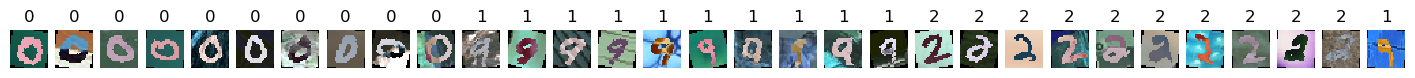

In [7]:
for x,y in source_meta_dataset:
    break
show_data(x.detach().numpy().transpose(0,2,3,1),list(np.repeat(range(WAYS),SHOTS))+[y.detach().numpy()])

* dataloader: torch 本身的dataloader class，可以將上述loader的function做batching，以及安排shuffle和多線程等動作

In [17]:
# source跟target都使用小batch size
BS_TRAIN=8
BS_TEST=16
source_meta_dataloader=tud.DataLoader(source_meta_dataset, 
                    batch_size=BS_TRAIN,
                    shuffle=False,
                    num_workers=2,
                    pin_memory=True)

## 2.模型訓練

### 2.1 Construct Model
首先指定Feature Extractor，這邊用我們做好的model:
* latent_dims: 可以調整 latent dimension，生成不一樣的FeatureExtractor
    
Model這邊只有Prototypical Network可選

In [10]:
from torch import nn
from supp.nn_model import (FeatureExtractor,PrototypicalNet,cosine)

#@title Model Hyper Parameters for Prototypical Network
#@markdown Latent space dimension
latent_dims=16 #@param
#@markdown Model (meta learning): Prototypical Netwrok
backbone=FeatureExtractor(latent_features=latent_dims)
model=PrototypicalNet(WAYS,SHOTS,backbone,cosine).cuda()

若有調整model可以看一下summary確定axis數、每個axis維度是否如預期

In [11]:
# !pip install torchsummary
# from torchsummary import summary
# summary(backbone, (3, 224, 224))

### 2.2 Training Loss& Optimizer
可以當成一般分類問題來給訂相關loss、optimizer

**Loss function(criterion)**
* cce: CrossEntropyLoss
* focal: FocalLoss
* addmargin: AddMarginLoss
* arcmargin: ArcMarginLoss

In [12]:
from torch import nn
from supp.nn_model import (FocalLoss,AddMarginLoss,ArcMarginLoss)

#@title Loss (meta learning)
#@markdown export criterion=LossClass(*args)
loss_type="addmargin" #@param ["cce","focal","addmargin","arcmargin"]
if loss_type=="cce":
    criterion = nn.CrossEntropyLoss()
elif loss_type=="focal":
    criterion = FocalLoss(gamma=2)
elif loss_type=="addmargin":
    criterion = AddMarginLoss(s=15.0, m=0.40,ways=WAYS,loss_fn=FocalLoss())
elif loss_type=="arcmargin":
    criterion = ArcMarginLoss(s=32.0, m=0.40,ways=WAYS, easy_margin=False,loss_fn=FocalLoss())
else:
    print("unrecognizable loss")

**Optimizer**
* 這邊使用Adam來作optimization，且三個子模型要分開，因為每個訓練step會有兩個部分:
    * 訓練domain classifier
    * 訓練label predictor+feature extractor

In [13]:
import torch.optim as optim
# 為了方便我們令一個class可以直接把dictionary key變成其attribute (可以直接用d.key)
lr=0.001
optimizer=optim.Adam(model.parameters(),lr=lr)

### 2.3 Training Parameters& Callbacks

**Parameters**
- EPOCHS: 先設一個很大的數，當訓練不下去時也可以手動停止

- INNER_LOOPS: 每個meta batch可以多train幾次，增加強度

**Callbacks**
- Learning rate scheduling: ReduceLROnPlateau-模型訓練不下去時learning rate減少


In [14]:
EPOCHS=15
# For scheduler
# scheduler=optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.1, patience=5)

### 2.4 Source data Training

In [15]:
from tqdm.notebook import tqdm
def train_epoch(epoch,model,criterion,optimizer,dataloader,ismeta=True):
    running_loss = 0.0 # Feature Extrator & Label Predictor的loss
    total_hit, total_num = 0.0, 0.0 # total_hit: 計算目前對了幾筆 total_num: 目前經過了幾筆
    session=tqdm(enumerate(dataloader))
    for i, (data, label) in session:
        data = data.cuda()
        label = label.cuda()

        # 訓練整個model
        if ismeta:
            class_logits = model.meta_forward(data)
        else:
            class_logits=model(data)
        # loss以指定的為主
        loss = criterion(class_logits, label)
        loss.backward()

        optimizer.step()
        # scheduler.step(loss) # For scheduler
        optimizer.zero_grad()

        running_loss+= loss.item()
        total_hit += torch.sum(torch.argmax(class_logits, dim=1) == label).item()
        total_num += data.shape[0]

        session.set_postfix({"epoch":epoch,"loss":loss.item(),"acc":total_hit / total_num})
    return running_loss / (i+1), total_hit / total_num

In [18]:
# 訓練 Source
try:
    for epoch in range(EPOCHS):
        train_loss, train_acc = train_epoch(epoch,model,criterion,optimizer,source_meta_dataloader,ismeta=True)
        torch.save(model.state_dict(), f'proto_{loss_type}.bin')
except KeyboardInterrupt:
    print("KeyboardInterrupt")

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

## 3.預測&評估

### 3.1 Meta Test on Target Data

In [19]:
target_meta_dataset=MetaLearningDataset(test_dataset,test_dataset.classes,WAYS,SHOTS,10)
target_meta_dataloader=tud.DataLoader(target_meta_dataset, 
                    batch_size=BS_TEST,
                    shuffle=False,
                    num_workers=2,
                    pin_memory=True)

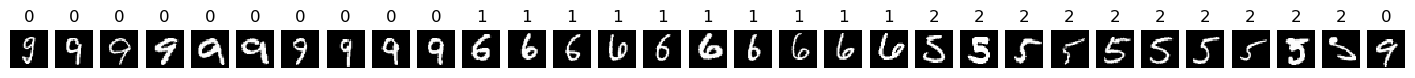

In [20]:
for x,y in target_meta_dataset:
    break
show_data(x.detach().numpy().transpose(0,2,3,1),list(np.repeat(range(WAYS),SHOTS))+[y.detach().numpy()])

In [32]:
def run_test(model,data_loader,ismeta=True):
    result = dict(y_true=[],y_pred=[])
    total_test_hit, total_test_num = 0.0, 0.0
    with torch.no_grad():
        for i, (data,label) in enumerate(data_loader):
            test_data = data.cuda()
            test_label = label.cuda()
            
            if ismeta:
                class_logits = model.meta_forward(test_data)
            else:
                class_logits = model(test_data)
                
            pred = torch.argmax(class_logits, dim=1).cpu().detach().numpy()
            result['y_true'].extend(label.cpu().detach().numpy())
            result['y_pred'].extend(pred)
            
            total_test_hit += torch.sum(torch.argmax(class_logits, dim=1) == test_label).item()
            total_test_num += test_data.shape[0]

    print("test acc:",total_test_hit / total_test_num)
    return result,total_test_hit / total_test_num

In [33]:
model.eval()
pred,acc=run_test(model,target_meta_dataloader,ismeta=True)

test acc: 1.0


### 3.2 Teting Target Task with Different N, K

In [25]:
TGT_WAYS=len(target_dataset.classes)
TGT_SHOTS=10

In [26]:
from supp.fsl_dataset import FewShotSampler    
# 使用剛剛transfer learning的sampler 對target data進行sample 模擬N-way-k的情況
sampler=FewShotSampler(target_dataset,
                       classes=target_dataset.classes[:TGT_WAYS],
                       shots=TGT_SHOTS,repeats=1,shuffle=False) #注意這邊若是Metric Learning Shuffle要關掉

In [27]:
# 然後把每個用stack疊起來多一個rank，大小變成[TGT_WAYS*TGT_SHOTS,CH,W,H]
tgt_support_x=torch.stack([target_dataset[idx][0] for idx in sampler])
# 把y也拿起來做對照 (這邊只是對照而已後面用不到)
tgt_support_y=np.array([target_dataset[idx][1] for idx in sampler])

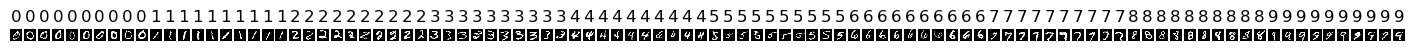

In [28]:
show_data(tgt_support_x.detach().numpy().transpose(0,2,3,1),tgt_support_y)

In [29]:
# 對於待測dataset,形成loader
test_dataloader = tud.DataLoader(test_dataset,
                             batch_size=BS_TEST,
                             shuffle=False,
                             num_workers=2,
                             pin_memory=True)

In [39]:
#@title Target Model Variation
#@markdown Model (meta learning): Prototypical Netwrok
model_tgt=PrototypicalNet(TGT_WAYS,TGT_SHOTS,backbone,cosine).cuda()
#@markdown Loss (transfer learning): export criterion=LossClass(*args)
loss_type="addmargin" #@param ["cce","focal","addmargin","arcmargin"]
if loss_type=="cce":
    criterion_tgt = nn.CrossEntropyLoss()
elif loss_type=="focal":
    criterion_tgt = FocalLoss(gamma=2)
elif loss_type=="addmargin":
    criterion_tgt = AddMarginLoss(s=15.0, m=0.40,ways=TGT_WAYS,loss_fn=FocalLoss())
elif loss_type=="arcmargin":
    criterion_tgt = ArcMarginLoss(s=32.0, m=0.40,ways=TGT_WAYS, easy_margin=False,loss_fn=FocalLoss())
else:
    print("unrecognizable loss")

backbone.eval()
# 將n-way-k-shot的support data形成prototype以供inference
model_tgt.save_prototypes(tgt_support_x.cuda())
optimizer_tgt=optim.Adam(model_tgt.parameters(),lr=lr*10)

In [40]:
# 使用test dataloader觀察testing效果
model_tgt.eval()
pred,acc=run_test(model_tgt,test_dataloader,ismeta=False)

test acc: 0.8692


In [41]:
from sklearn.metrics import confusion_matrix,classification_report

In [42]:
print(classification_report(pred['y_true'], pred['y_pred']))

              precision    recall  f1-score   support

           0       0.85      0.96      0.90       460
           1       0.89      0.98      0.93       571
           2       0.93      0.78      0.85       530
           3       0.82      0.87      0.85       500
           4       0.88      0.91      0.89       500
           5       0.88      0.83      0.85       456
           6       0.90      0.93      0.91       462
           7       0.86      0.88      0.87       512
           8       0.89      0.74      0.81       489
           9       0.80      0.81      0.81       520

    accuracy                           0.87      5000
   macro avg       0.87      0.87      0.87      5000
weighted avg       0.87      0.87      0.87      5000



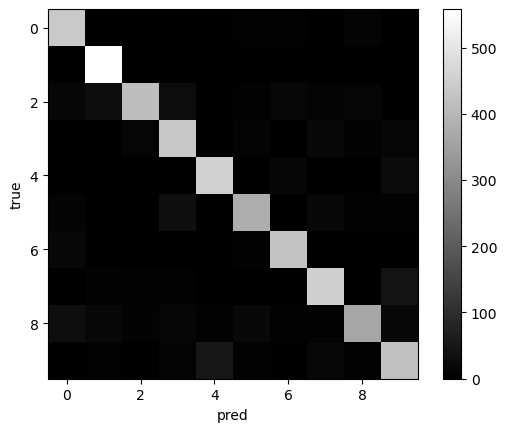

In [43]:
plt.imshow(confusion_matrix(pred['y_true'], pred['y_pred']),'gray')
plt.colorbar()
plt.ylabel("true")
plt.xlabel("pred");plt.show()

### 3.2 Adaptation Training & Evaluation

In [44]:
# 對於target support dataset,形成loader
sampler.shuffle=True
target_dataloader2=tud.DataLoader(target_dataset, 
                    batch_size=BS_TRAIN,
                    shuffle=False,sampler=sampler)

In [45]:
# Random Inspect parameters before fine-tuning
model_tgt.weight[0]

tensor([0.0000, 1.4207, 0.0247, 0.3989, 0.0000, 0.0000, 0.1074, 0.0000, 0.0566,
        0.0000, 0.0000, 2.2878, 1.3939, 0.0000, 2.5857, 0.8532],
       device='cuda:0', grad_fn=<SelectBackward0>)

In [46]:
# 使用Target 中support set額外做adaptation
model_tgt.train()
try:
    for epoch in range(8):
        train_loss, train_acc = train_epoch(epoch,model_tgt,criterion_tgt,optimizer_tgt,target_dataloader2,ismeta=False)
        torch.save(model_tgt.state_dict(), f'proto_{loss_type}_adapted.bin')
except KeyboardInterrupt:
    print("KeyboardInterrupt")

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

In [47]:
# Random Inspect parameters after fine-tuning
model_tgt.weight[0]

tensor([-2.4172e-01,  1.1309e+00,  1.2576e-02,  3.6071e-01, -2.5485e-01,
         2.6223e-02,  1.8444e-02, -2.8307e-01, -4.6417e-02,  6.0551e-02,
         5.7500e-04,  2.5181e+00,  1.4996e+00, -1.9178e-02,  2.5432e+00,
         5.2207e-01], device='cuda:0', grad_fn=<SelectBackward0>)

In [51]:
# 使用test dataloader觀察testing效果
model_tgt.eval()
pred,acc=run_test(model_tgt,test_dataloader,ismeta=False)

test acc: 0.6056


In [52]:
print(classification_report(pred['y_true'], pred['y_pred']))

              precision    recall  f1-score   support

           0       1.00      0.48      0.65       460
           1       0.40      0.99      0.57       571
           2       1.00      0.05      0.10       530
           3       0.84      0.13      0.23       500
           4       0.72      0.89      0.79       500
           5       0.84      0.27      0.41       456
           6       0.67      0.84      0.74       462
           7       0.66      0.76      0.71       512
           8       0.56      0.81      0.66       489
           9       0.64      0.78      0.70       520

    accuracy                           0.61      5000
   macro avg       0.73      0.60      0.56      5000
weighted avg       0.73      0.61      0.56      5000



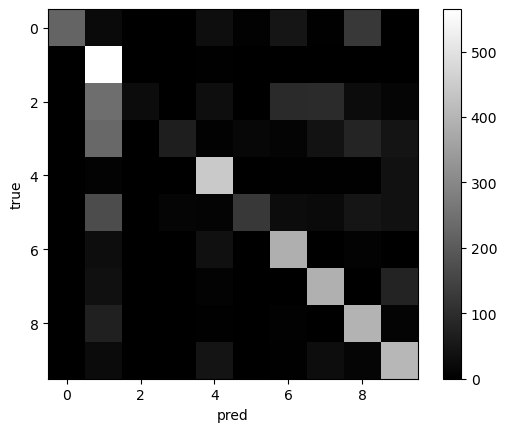

In [53]:
plt.imshow(confusion_matrix(pred['y_true'], pred['y_pred']),'gray')
plt.colorbar()
plt.ylabel("true")
plt.xlabel("pred");plt.show()

## 4.練習

1. 這次練習的是使用雜色的MNIST-M做source meta train，MNIST作為meta test，請試著把兩個資料集倒過來
2. 嘗試不同的source training組合:
    - cce & focal loss & addmargin loss & arcmargin loss
3. 嘗試不同target training組合:
    - cce & focal loss & addmargin loss & arcmargin loss
4. 將target way數, shot數改變為5way 5 shot，試著調整出最佳組合


## 5.參考資料

* [Snell, J., Swersky, K., & Zemel, R. S. (2017). Prototypical networks for few-shot learning. arXiv preprint arXiv:1703.05175.](https://arxiv.org/abs/1703.05175)
    - Prototypical networks原文
* [Lin, T. Y., Goyal, P., Girshick, R., He, K., & Dollár, P. (2017). Focal loss for dense object detection. In Proceedings of the IEEE international conference on computer vision (pp. 2980-2988). ](https://arxiv.org/abs/1708.02002v2)
    - Focal Loss原文
* [Wang, H., Wang, Y., Zhou, Z., Ji, X., Gong, D., Zhou, J., ... & Liu, W. (2018). Cosface: Large margin cosine loss for deep face recognition. In Proceedings of the IEEE conference on computer vision and pattern recognition (pp. 5265-5274).](https://arxiv.org/abs/1801.09414)
    - CosineFace原文
* [Deng, J., Guo, J., Xue, N., & Zafeiriou, S. (2019). Arcface: Additive angular margin loss for deep face recognition. In Proceedings of the IEEE/CVF conference on computer vision and pattern recognition (pp. 4690-4699).](https://arxiv.org/abs/1801.07698)
    - ArcFace原文